# SISEPUEDE Tutorial #1 - Sector Models

Welcome to the **SImulation of SEctoral Pathways with Uncertainty Exploration for DEcarbonization (SISEPUEDE)** tutorials! This tutorial--_Sector Models_--walks users of the model through how to setup an individual sector model, run each model, and extract and plot output. Then, the tutorial walkks through running the integrated model (the DAG). By the end of the tutorial, users should be able to:

- Instantiate `AFOLU`, `CircularEconomy`, `EnergyConsumption`, `EnergyProduction`, `IPPU`, and `Socioeconomic` models
- **Project** each of the models using an input data frame and look through output
- Run the models in an integrated setup

This is a key tutorial for users that anticipate running the SISEPUEDE integrated emissions model.


##  Key Terminology

### Project

The term *project* is used to refere to running SISEPUEDE forward from its initial state. This choice of nomenclature keeps with its use in "projecting" future states (using simple assumptions about socioeconomics etc.) and its design as a simulation model.


### Sectors

SISEPUEDE is divided into 5 key sectors for accounting. These sectors are largely self contained--where inputs can be defined separately. This was purposely implemented to allow sectoral teams to focus on developing and maintaining relevant input data for their sector, but then allowing straightforward integration of models by teams in a uniform modeling system. The sectors are based on volumes of the IPCC Guidelines for National Greenhouse Gas Inventories. 

In general, each sector corresopnds with a sector model, though energy is divided into `EnergyConsumption` and `EnergyProduction`. This simplifies energy (e.g., SISEPUEDE does not capture how electric vehicles could act as generators in certain situations).


### Subsectors

Each sector is associated with multiple subsectors. Subsectors are designed around two key themes: the IPPC guidelines and modeling functionality. Most subsectors are defined as emissions subectors--e.g., Agriculture, Land Use, Solid Waste, Transportation, IPPU, etc.--but some are modeling subsectors that allow for the integration of new categories. For example `Liquid Waste` is a modeling subsector that allows quantification of liquid waste in different populations, but it does not generate emissions. Emissions are handled in the `Wastewater Treatement` subsector. Some models allow individual subsector models to run independently--this is largely true in `EnergyConsumption`--but some, like `AFOLU` are too integrated to allow for individiaul subsector runs because of high degrees of interdependency.

## More information is available on the [SISEPUEDE ReadTheDocs](https://sisepuede.readthedocs.io/en/latest/)




In [1]:
import warnings
warnings.filterwarnings("ignore")

import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede.plotting.plots as spl
import sisepuede.utilities._plotting as sup
import sys
from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure



# First, we access the file structure to get the `ModelAttributes` object

- The `sisepuede_file_structure.SISEPUEDEFileStructure` object stores relevant paths and the general file structure of the entire system It's a key piece of the `SISEPUEDE` object; however, we can use it to look at the most important object in the ecosystem, the `ModelAttributes` object.

- Each subsector model relies on the `ModelAttributes` object to manage variables, categories, units (and associated conversions), and cross-sector interactions (see Tutorial 2 for a deeper diver on the `ModelAttributes` object).

- Time periods are stored in the ModelAttributes object and are derived from the `attribute_dim_time_period.csv` attribue file. The default range runs from 0-35 (2015 to 2050), but this can easily be modified for different runs.


See the **`tutorial-2`** notebook for more on these objects.

In [2]:
# initialize a file structure and model attributes
file_struct = SISEPUEDEFileStructure()
model_attributes = file_struct.model_attributes

# We can instantiate an object that stores all models at once, but let's explore them one by one

- Every model object is callable and has a `project` method.
- Every model takes a DataFrame as input and returns a DataFrame as output.
- Use the `SISEPUEDEExamples` object to grab a tutorial data frame
- Note: the model objects take inputs for:
    - **One** region
    - **One** scenario
    

In [3]:
# start with some example data
examples = SISEPUEDEExamples()
df_input = examples("input_data_frame")

In [4]:
model_attributes.build_variable_dataframe_by_sector(
    None,
    include_model_variable = True,
    include_model_variable_attributes = True,
    include_time_periods = False,
)

,subsector,variable_field,variable,area,energy,length,mass,monetary,power,volume,emission_gas
0,Agriculture,ef_agrc_anaerobicdom_rice_kg_ch4_ha,:math:\text{CH}_4 Crop Anaerobic Decomposition...,ha,None,None,kg,None,None,None,ch4
1,Agriculture,ef_agrc_biomass_bevs_and_spices_tonne_co2_ha,:math:\text{CO}_2 Crop Biomass Emission Factor,ha,None,None,tonne,None,None,None,co2
2,Agriculture,ef_agrc_biomass_burning_ch4,:math:\text{CH}_4 Crop Biomass Burning Emissio...,None,None,None,None,None,None,None,ch4
3,Agriculture,ef_agrc_biomass_burning_n2o,:math:\text{N}_2\text{O} Crop Biomass Burning ...,None,None,None,None,None,None,None,n2o
4,Agriculture,ef_agrc_biomass_fruits_tonne_co2_ha,:math:\text{CO}_2 Crop Biomass Emission Factor,ha,None,None,tonne,None,None,None,co2
...,...,...,...,...,...,...,...,...,...,...,...
2372,Wastewater Treatment,mcf_trww_treated_septic,Wastewater Treatment Methane Correction Factor,None,None,None,None,None,None,None,None
2373,Wastewater Treatment,mcf_trww_untreated_no_sewerage,Wastewater Treatment Methane Correction Factor,None,None,None,None,None,None,None,None
2374,Wastewater Treatment,mcf_trww_untreated_with_sewerage,Wastewater Treatment Methane Correction Factor,None,None,None,None,None,None,None,None
2375,Wastewater Treatment,physparam_krem_sludge_factor_treated_advanced_...,:math:\text{K}_{REM} Sludge Factor,None,None,None,None,None,None,None,None


##  Start with AFOLU
- Detailed sector information is available at the [SISEPUEDE Read the Docs (AFOLU)](https://sisepuede.readthedocs.io/en/latest/afolu.html)
- You can explore the arguments and keyword arguments using `?AFOLU` or `help(AFOLU)`

In [6]:
from sisepuede.models.afolu import AFOLU
?AFOLU

Init signature:
AFOLU(
    attributes: sisepuede.core.model_attributes.ModelAttributes,
    logger: Optional[logging.Logger] = None,
    npp_curve: Union[str, sisepuede.utilities._npp_curves.NPPCurve, NoneType] = None,
    npp_include_primary_forest: bool = False,
    npp_integration_windows: Union[list, tuple, numpy.ndarray] = [20, 480, 1000],
    **kwargs,
) -> None
Docstring:     
Use AFOLU to calculate emissions from Agriculture, Forestry, and Land Use 
    in SISEPUEDE. Includes emissions from the following subsectors:

    * Agriculture (AGRC)
    * Forestry (FRST)
    * Land Use (LNDU)
    * Livestock (LVST)
    * Livestock Manure Management (LSMM)
    * Soil Management (SOIL)

For additional information, see the SISEPUEDE readthedocs at:

    https://sisepuede.readthedocs.io/en/latest/afolu.html


Intialization Arguments
-----------------------
model_attributes : ModelAttributes
    ModelAttributes object used in SISEPUEDE to manage variables and 
    categories

Optional Argum

In [7]:
# initialize using only the model_attributes argument
model_afolu = AFOLU(model_attributes, )



##  You can project the model simply by calling it on the input data frame
- Runs all subsector models at the same time

In [8]:
df_out_afolu = model_afolu(df_input)


####  You can also see the subsectors associated with the sector using the `model_attributes.get_sector_subsectors`

In [9]:
model_attributes.get_sector_subsectors("AFOLU")

['Agriculture',
 'Forest',
 'Land Use',
 'Livestock Manure Management',
 'Livestock',
 'Soil Management']

###  You can see all variables associated with a subsector using the `model_attributes.get_subsector_variables` method
- Abstract variables are stored as `ModelVariable` objects
- Each `ModelVariable` is associated with a field schema, categories, and differet characteristics, such as gas and units
- Use `model_attributes.get_subsector_variables()` to list all (input and output) variables associated with a subsector

In [10]:
model_attributes.get_subsector_variables("Land Use")

[':math:\\text{CO}_2 Land Use Conversion Emission Factor',
 'Fraction of Increasing Net Exports Met',
 'Fraction of Increasing Net Imports Met',
 'Fraction of Pastures Improved',
 'Fraction of Soils Mineral',
 'Initial Land Use Area Proportion',
 'Land Use Biomass Sequestration Factor',
 'Land Use BOC :math:\\text{CH}_4 Emission Factor',
 'Land Use Fraction Dry',
 'Land Use Fraction Fertilized',
 'Land Use Fraction Temperate',
 'Land Use Fraction Tropical',
 'Land Use Fraction Wet',
 'Land Use Yield Reallocation Factor',
 'Maximum Area',
 'Maximum Pasture Dry Matter Yield Factor',
 'Maximum Soil Carbon Land Input Factor Without Manure',
 'Maximum Soil Carbon Land Management Factor',
 'Minimum Area',
 'Soil Carbon Land Use Factor',
 'Unadjusted Land Use Transition Probability',
 'Unimproved Soil Carbon Land Management Factor',
 'Utilization Rate',
 'Vegetarian Diet Exchange Scalar',
 ':math:\\text{CH}_4 Emissions from Wetlands',
 ':math:\\text{CO}_2 Emissions from Conversion Away from L

In [11]:
model_attributes.get_variable("Land Use Biomass Sequestration Factor")

ModelVariable: Land Use Biomass Sequestration Factor
Fields:
	ef_lndu_sequestration_grasslands_kt_co2_ha
	ef_lndu_sequestration_other_kt_co2_ha
	ef_lndu_sequestration_pastures_kt_co2_ha
	ef_lndu_sequestration_settlements_kt_co2_ha
	ef_lndu_sequestration_shrublands_kt_co2_ha
	ef_lndu_sequestration_wetlands_kt_co2_ha

###  You can also restrict variables to input or output using the `var_type` keyword argument
- set to "input" to see input variables only or "output" to see output variables only

In [12]:
model_attributes.get_subsector_variables(
    "Land Use",
    var_type = "output",
)


[':math:\\text{CH}_4 Emissions from Wetlands',
 ':math:\\text{CO}_2 Emissions from Conversion Away from Land Use Type',
 ':math:\\text{CO}_2 Emissions from Land Use Biomass Sequestration',
 ':math:\\text{CO}_2 Emissions from Land Use Conversion',
 'Area of Improved Land',
 'Area of Land Use Converted',
 'Area of Land Use Converted Away from Type',
 'Area of Land Use Converted to Type',
 'Land Use Area']

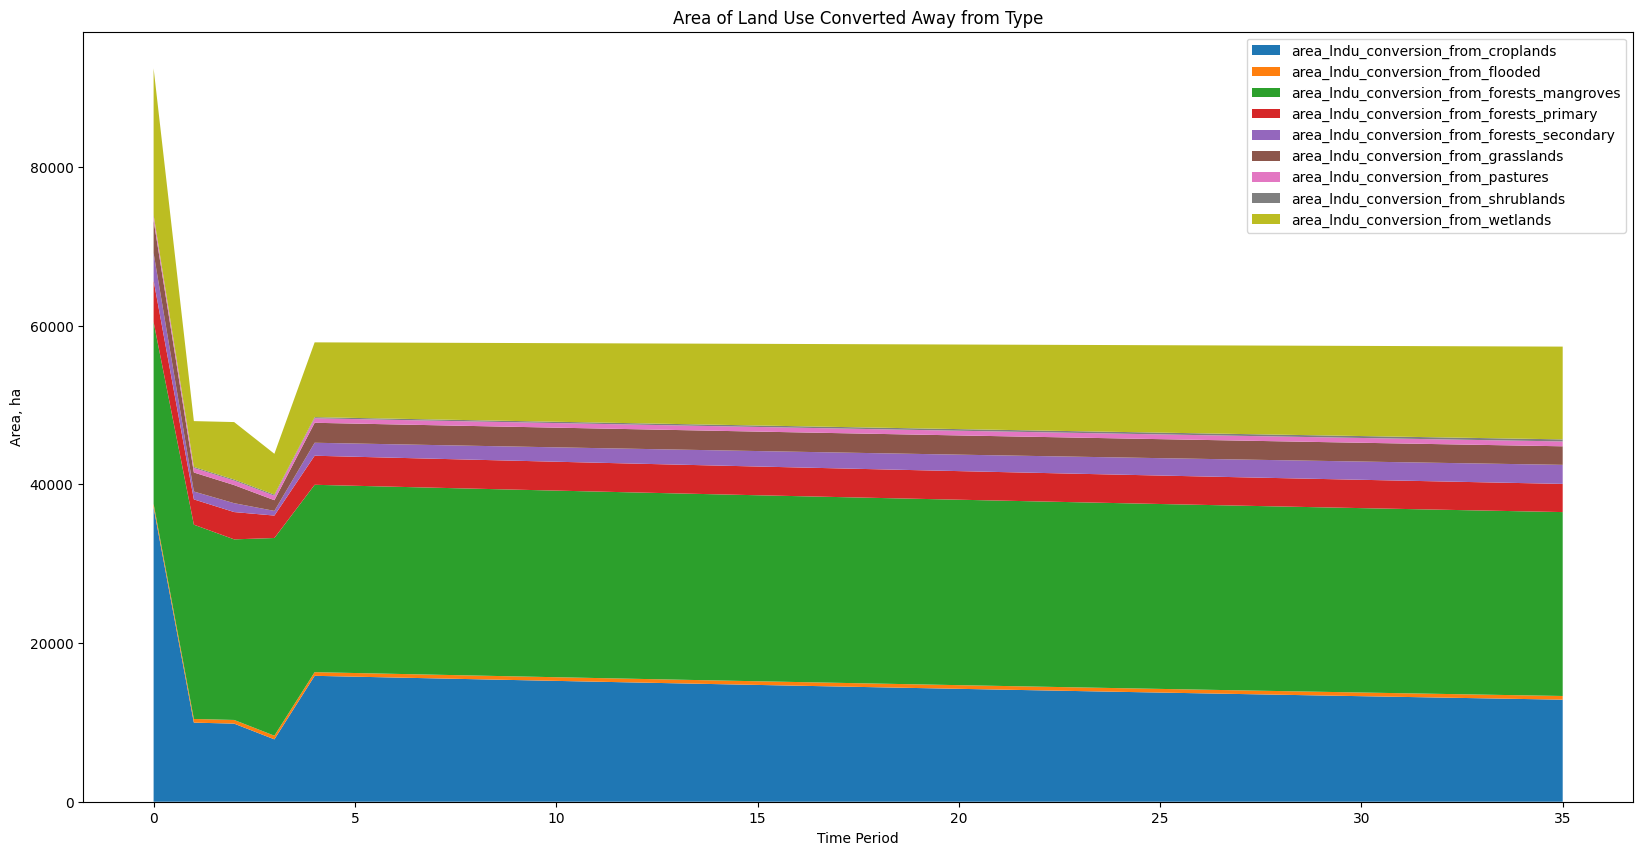

In [13]:
# retrieve ModelVariable for Land Use Area
modvar = model_attributes.get_variable("Area of Land Use Converted Away from Type")
fields = [
    x for x in modvar.fields if df_out_afolu[x].max() > 0
]
# format the figure
fig, ax = plt.subplots(figsize = (20, 10))

ax.set_xlabel("Time Period")
ax.set_ylabel("Area, ha")
ax.set_title(modvar.name)


sup.plot_stack(
    df_out_afolu,
    fields,
    #model_attributes,
    figtuple = (fig, ax, ),
)

ax.legend(loc = "upper right")




###  Visualize some output--e.g., start with **`Land Use Area`**

**NOTE**: The name of a variable--such as `Land Use Area` can be retrieved from the attribute tables on [Read the Docs](https://sisepuede.readthedocs.io)

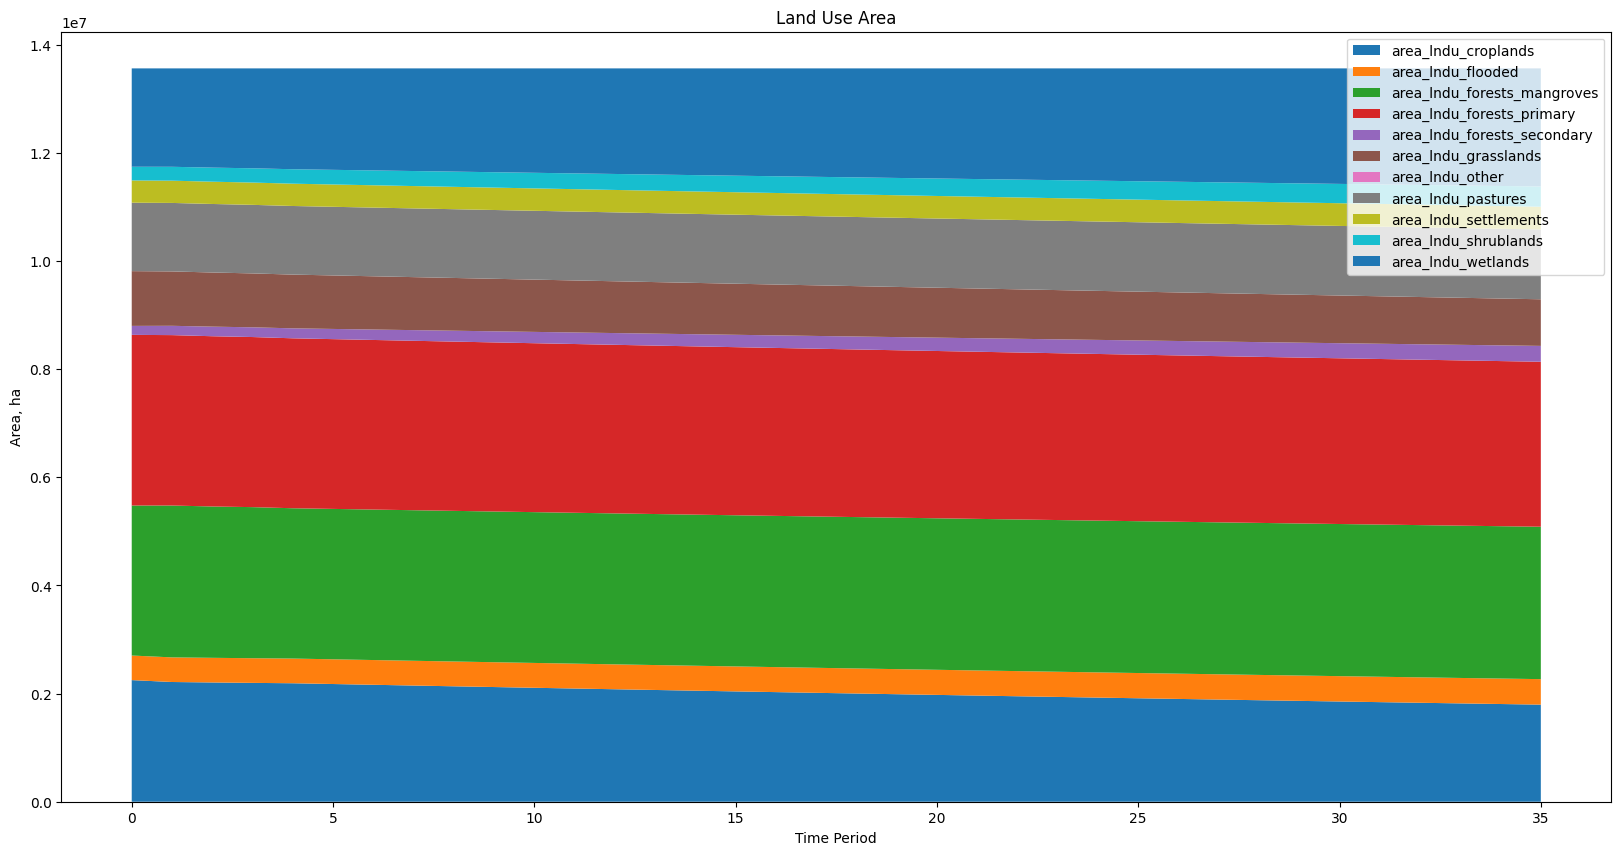

In [16]:
# retrieve ModelVariable for Land Use Area
modvar = model_attributes.get_variable("Land Use Area")

# format the figure
fig, ax = plt.subplots(figsize = (20, 10))

ax.set_xlabel("Time Period")
ax.set_ylabel("Area, ha")
ax.set_title(modvar.name)


spl.plot_variable_stack(
    df_out_afolu,
    modvar,
    model_attributes,
    figtuple = (fig, ax, ),
)

ax.legend(loc = "upper right")




###  Look at **`CO2 Emissions from Forest Biomass Sequestration`**

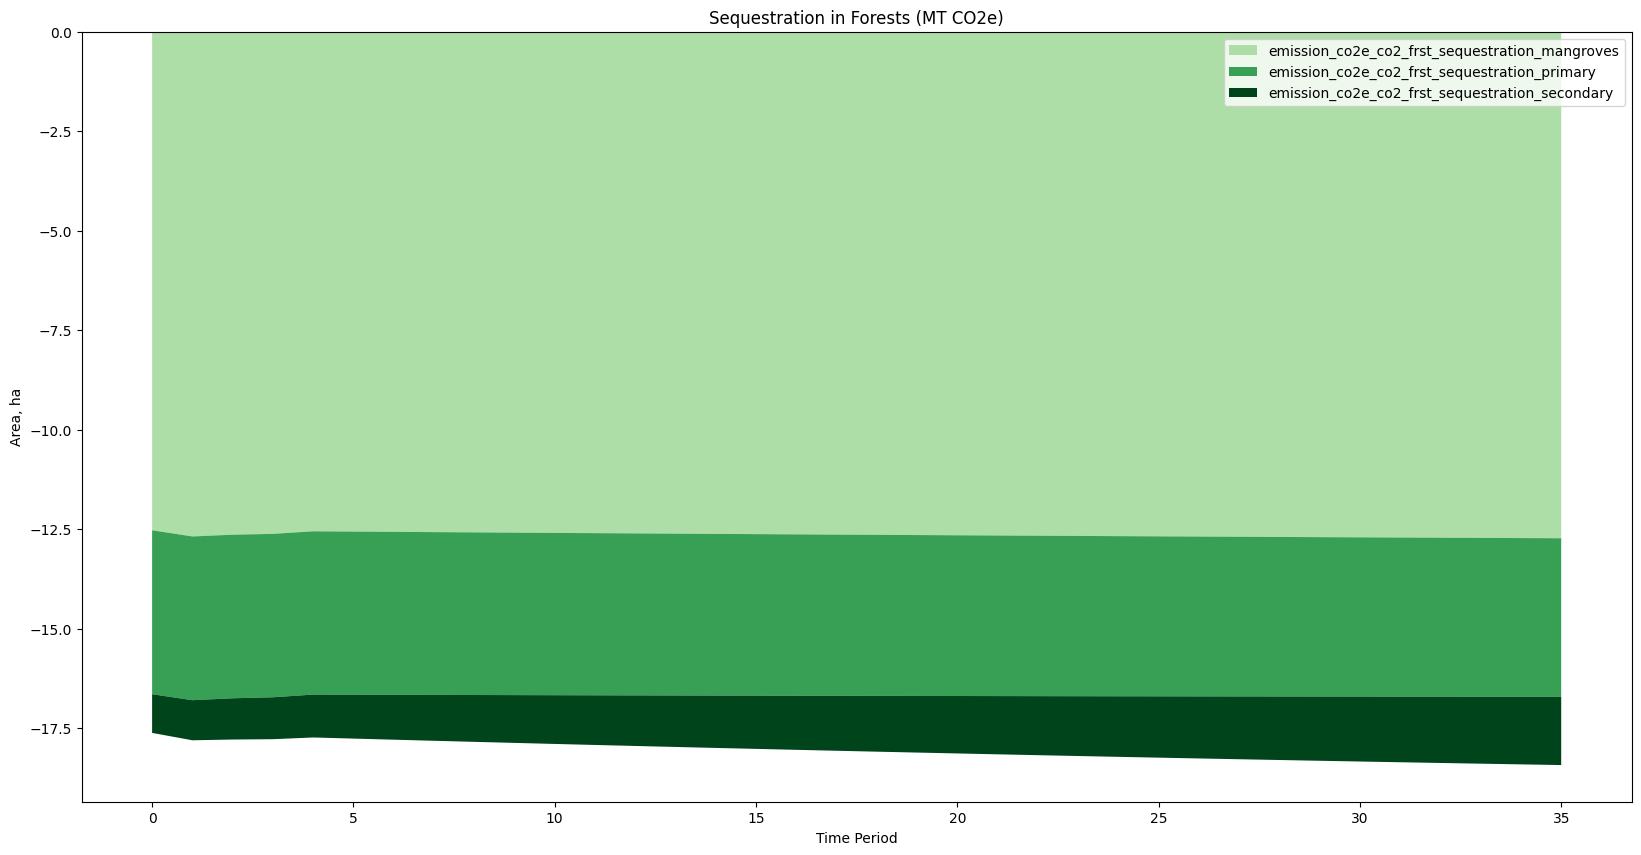

In [12]:
# retrieve ModelVariable for Forest Sequestration
modvar = model_attributes.get_variable(":math:\\text{CO}_2 Emissions from Forest Biomass Sequestration")
fields = modvar.fields

# setup figure
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_xlabel("Time Period")
ax.set_ylabel("Area, ha")
ax.set_title("Sequestration in Forests (MT CO2e)")

# optional info on setting colors
cmap = plt.colormaps["Greens"]#tab10
colors = [cmap(x/len(fields)) for x in range(1, len(fields) + 1)]
dict_format = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),


spl.plot_variable_stack(
    df_out_afolu,
    modvar,
    model_attributes,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),
    figtuple = (fig, ax, ),
)

# set the legend
ax.legend(loc = "upper right")





##  Subsector total emissions for a single subsector can be accessed using `ModelAttributes.get_subsector_emission_total_field()`


In [13]:
# e.g., look at livestock aggregate CO2e emissions
model_attributes.get_subsector_emission_total_field("Livestock")

'emission_co2e_subsector_total_lvst'

##  Get all emission total fields associated with a sector using `model_attributes.get_sector_emission_total_fields()`

In [14]:
fields_subsector_total = model_attributes.get_sector_emission_total_fields("AFOLU")
fields_subsector_total

['emission_co2e_subsector_total_agrc',
 'emission_co2e_subsector_total_frst',
 'emission_co2e_subsector_total_lndu',
 'emission_co2e_subsector_total_lsmm',
 'emission_co2e_subsector_total_lvst',
 'emission_co2e_subsector_total_soil']

###   Note that historical data is a part of runs, so non-smooth shapes can show up as year-to-year changes are often not smooth

- Note below total sequestration from forests

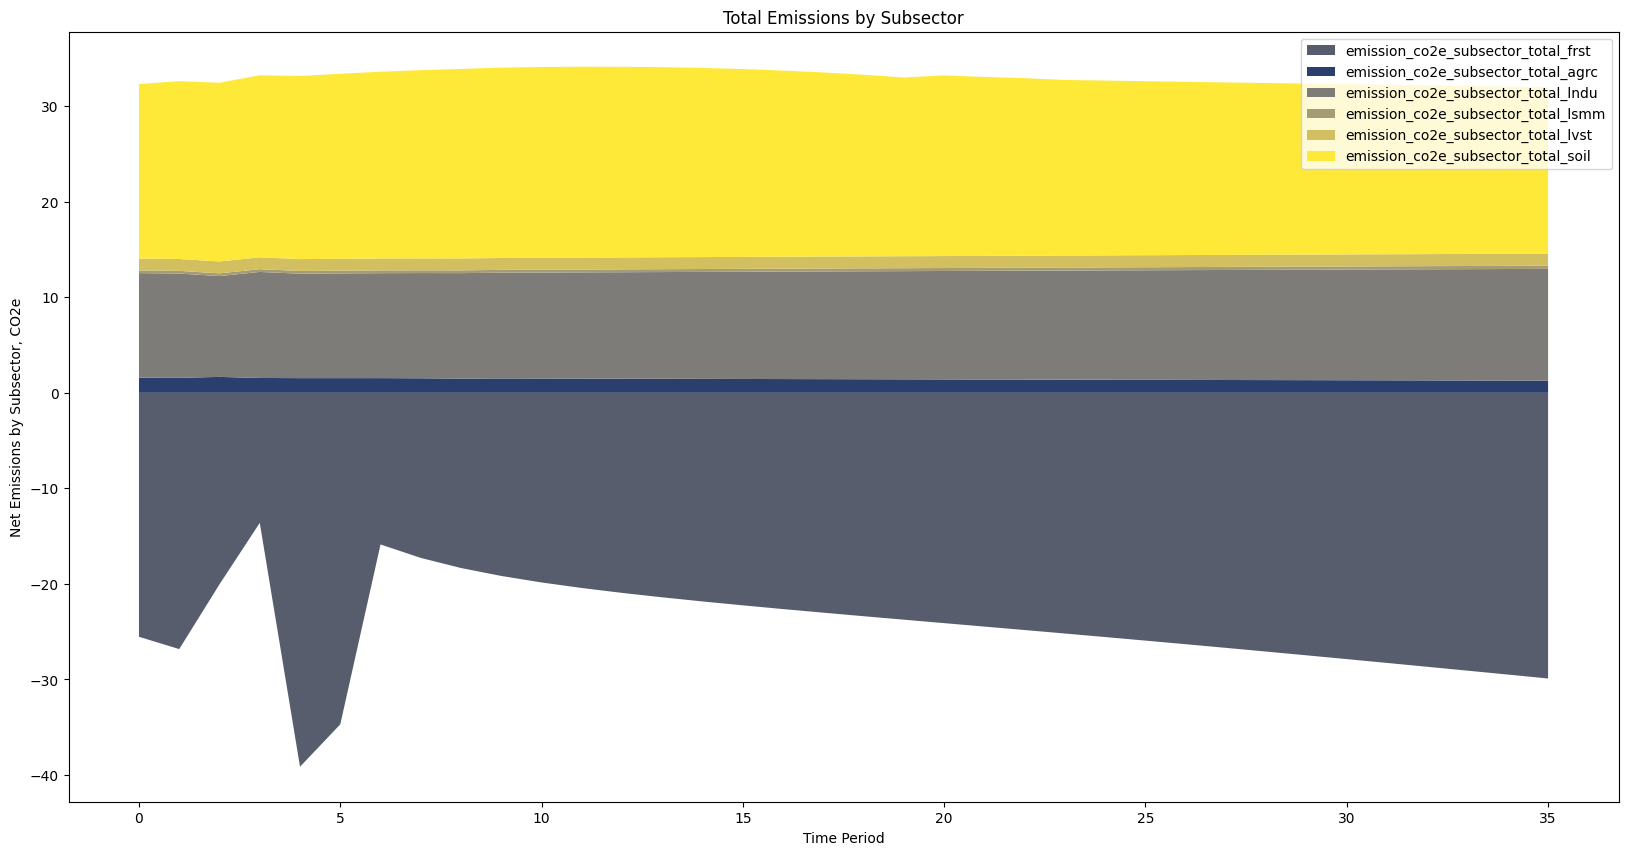

In [15]:
# setup figure
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_xlabel("Time Period")
ax.set_ylabel("Net Emissions by Subsector, CO2e")
ax.set_title("Total Emissions by Subsector")


# can format 
cmap = plt.colormaps["cividis"]
colors = [cmap(x/len(fields_subsector_total)) for x in range(1, len(fields_subsector_total) + 1)]
dict_format = dict((x, {"color": colors[i] }) for i, x in enumerate(fields_subsector_total)),


sup.plot_stack(
    df_out_afolu,
    fields_subsector_total,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields_subsector_total)),
    figtuple = (fig, ax),
)
ax.legend(loc = "upper right")

# Take a look at `CircularEconomy`

- Detailed sector information is available at the [SISEPUEDE Read the Docs (CircularEconomy)](https://sisepuede.readthedocs.io/en/latest/https://sisepuede.readthedocs.io/en/latest/circular_economy.html)
- **`CircularEconomy`** is dependent on **`AFOLU`** in the SISEPUEDE DAG, meaning that inputs depend on outputs from AFOLU when running integrated.
- However, we can run it independently without issue (for demonstration purposes)

In [17]:
from sisepuede.models.circular_economy import CircularEconomy


### Setup the model object

In [18]:
model_circecon = CircularEconomy(model_attributes, )

###  Run the `CircularEconomy` model
- Runs all subsectors at the same time

In [19]:
df_out_circecon = model_circecon(df_input)

###  See the subsectors contained in `CircularEconomy`

In [18]:
model_attributes.get_sector_subsectors("Circular Economy")


['Liquid Waste', 'Solid Waste', 'Wastewater Treatment']

###  Once again, see which variables are available for access

In [20]:
model_attributes.get_subsector_variables(
    "Wastewater Treatment", 
    var_type = "output"
)

[':math:\\text{CH}_4 Emissions from Wastewater Treatment',
 ':math:\\text{N}_2\\text{O} Emissions from Wastewater Effluent',
 ':math:\\text{N}_2\\text{O} Emissions from Wastewater Treatment',
 'Biogas Recovered from Wastewater Treatment Plants',
 'Mass of Sludge Produced',
 'Total BOD Organic Waste in Effluent',
 'Total BOD Removed in Treatment',
 'Total COD Organic Waste in Effluent',
 'Total COD Removed in Treatment',
 'Total Nitrogen Removed in Treatment',
 'Total Nitrogen in Effluent',
 'Total Phosphorous Removed in Treatment',
 'Total Phosphorous in Effluent',
 'Volume of Wastewater Treated']

###  Take a look at `:math:\\text{CH}_4 Emissions from Wastewater Treatment`

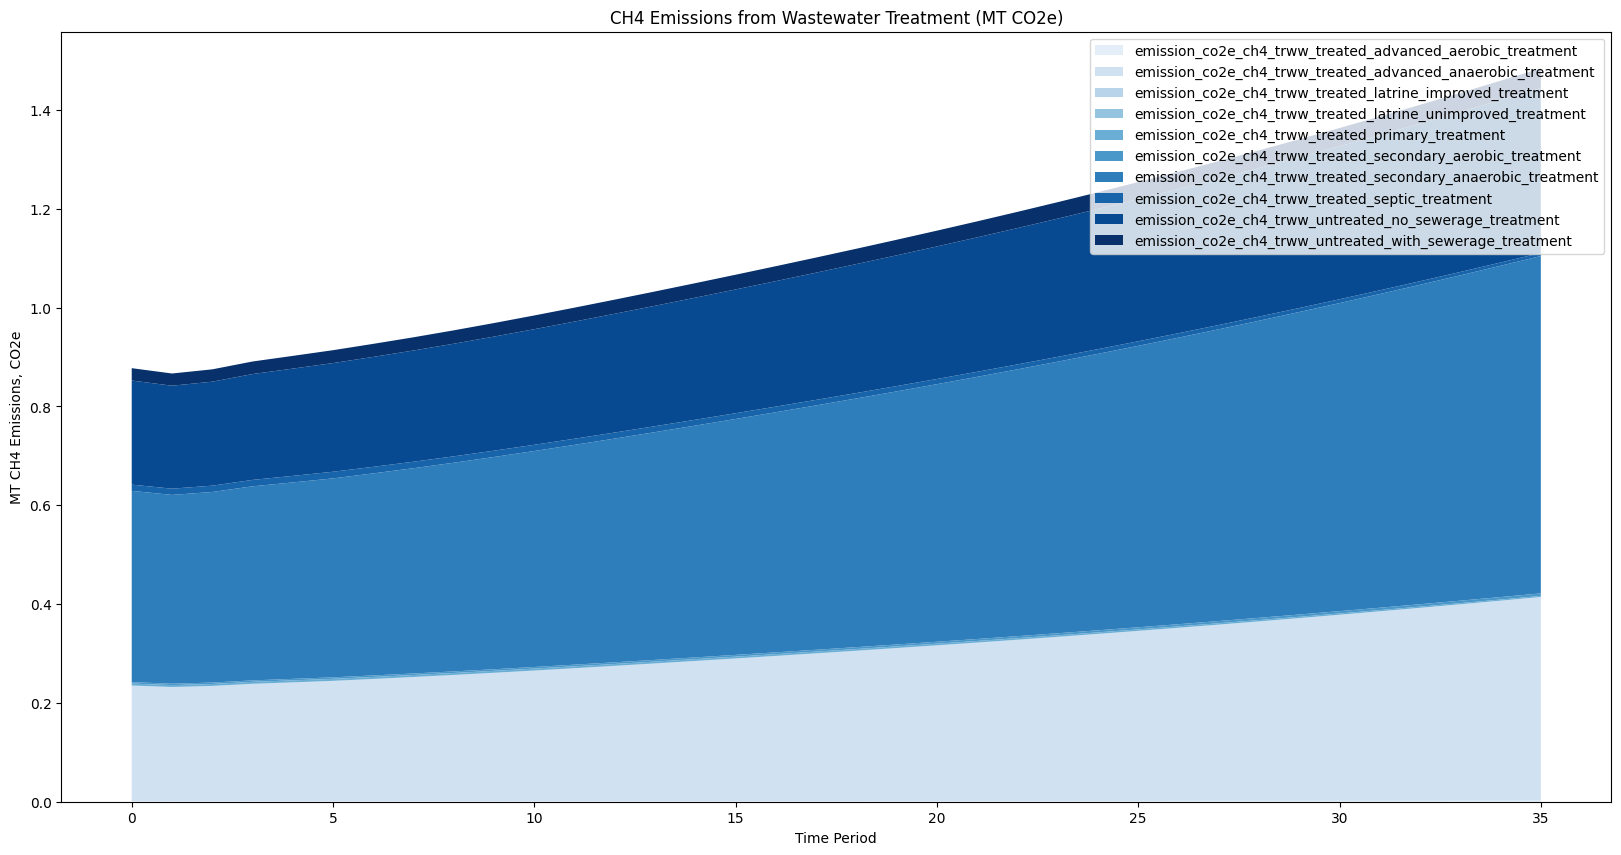

In [21]:

# get forest biomass sequestration
modvar = model_attributes.get_variable(":math:\\text{CH}_4 Emissions from Wastewater Treatment")
fields = modvar.fields

# setup figure
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT CH4 Emissions, CO2e")
ax.set_title("CH4 Emissions from Wastewater Treatment (MT CO2e)")

# optional info on setting colors
cmap = plt.colormaps["Blues"]#tab10
colors = [cmap(x/len(fields)) for x in range(1, len(fields) + 1)]
dict_format = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),


spl.plot_variable_stack(
    df_out_circecon,
    modvar,
    model_attributes,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),
    figtuple = (fig, ax, ),
)

# set the legend
ax.legend(loc = "upper right")





###  Take a look at aggregate emissions

Note: these emissions will be slightly different when integrated with AFOLU; for example, sludge from circular economy can be passed to AFOLU and waste from AFOLU is passed to Circular Economy.

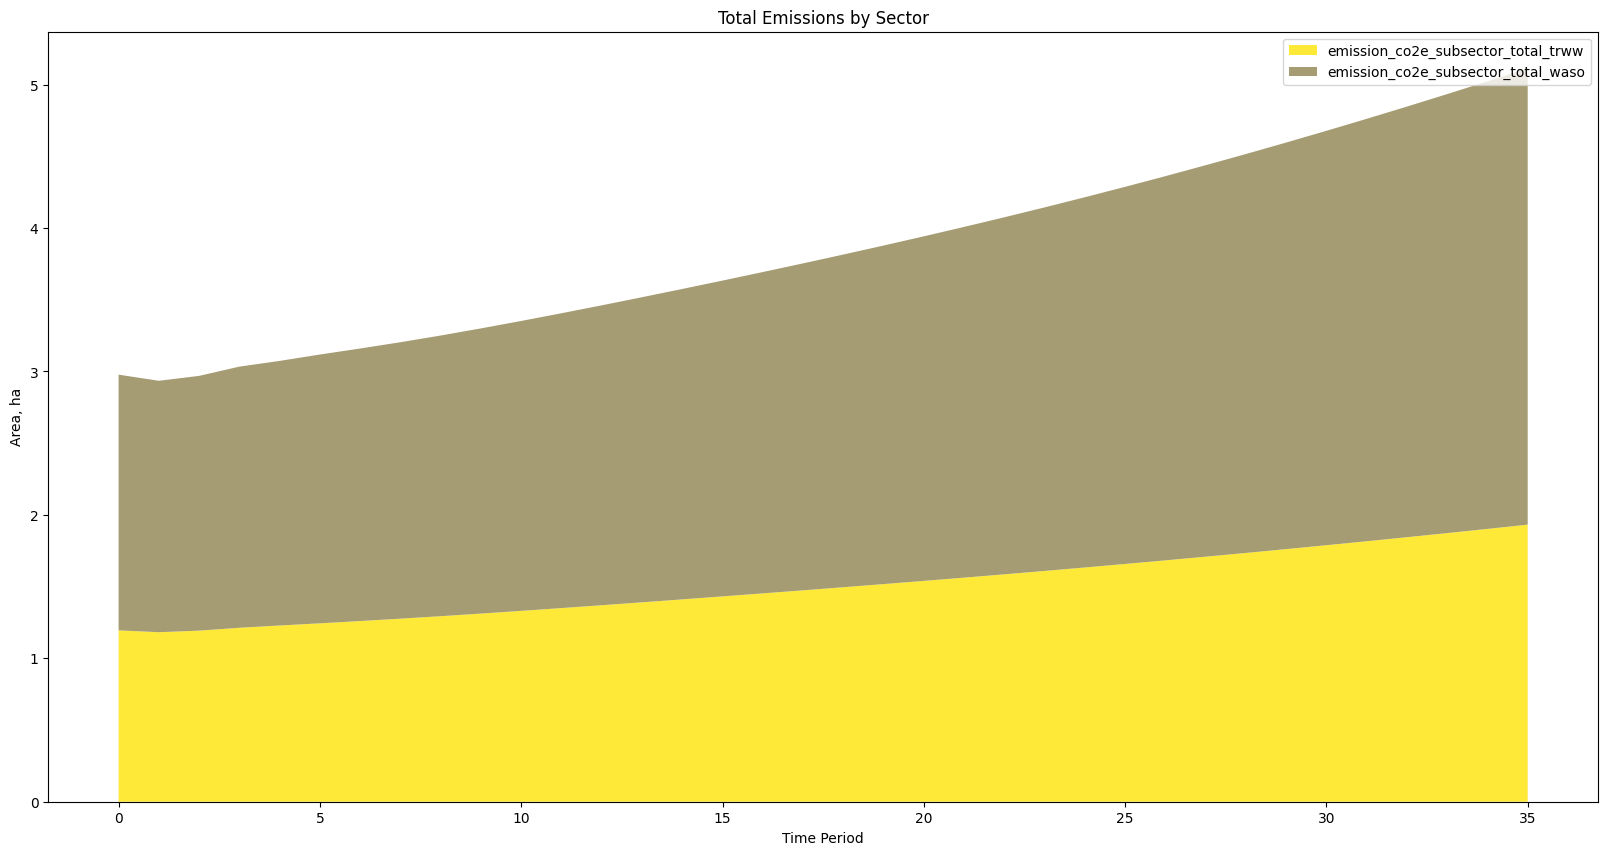

In [21]:
fields_subsector_total = model_attributes.get_sector_emission_total_fields("Circular Economy")

# setup figure
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_xlabel("Time Period")
ax.set_ylabel("Area, ha")
ax.set_title("Total Emissions by Sector")


# can format 
cmap = plt.colormaps["cividis"]
colors = [cmap(x/len(fields_subsector_total)) for x in range(1, len(fields_subsector_total) + 1)]
dict_format = dict((x, {"color": colors[i] }) for i, x in enumerate(fields_subsector_total)),


sup.plot_stack(
    df_out_circecon,
    fields_subsector_total,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields_subsector_total)),
    figtuple = (fig, ax),
)
ax.legend(loc = "upper right")

# Try exploring the `IPPU` model

- Instantiate the IPPU model as `model_ippu` using `IPPU` class
- You can check required arguments using `?IPPU` or `help(IPPU)`--like `AFOLU` and `CircularEconomy`, it requires the `ModelAttributes` object to initialize

In [15]:
from sisepuede.models.ippu import IPPU

In [23]:
# instantiate model_ippu here
model_ippu = IPPU(model_attributes, )

In [24]:
# try running the model here
model_ippu(df_input)

,time_period,dem_ippu_harvested_wood_tonne_paper,dem_ippu_harvested_wood_tonne_wood,emission_co2e_c2f6_ippu_product_use_product_use_ods_other,emission_co2e_c2f6_ippu_production_chemicals,emission_co2e_c2f6_ippu_production_electronics,emission_co2e_c2f6_ippu_production_metals,emission_co2e_c2h3f3_ippu_product_use_product_use_ods_refrigeration,emission_co2e_c2h3f3_ippu_production_chemicals,emission_co2e_c2hf5_ippu_product_use_product_use_ods_other,...,prod_ippu_textiles_tonne,prod_ippu_wood_tonne,qty_ippu_recycled_glass_used_in_production_tonne,qty_ippu_recycled_metals_used_in_production_tonne,qty_ippu_recycled_paper_used_in_production_tonne,qty_ippu_recycled_plastic_used_in_production_tonne,qty_ippu_recycled_rubber_and_leather_used_in_production_tonne,qty_ippu_recycled_textiles_used_in_production_tonne,qty_ippu_recycled_wood_used_in_production_tonne,emission_co2e_subsector_total_ippu
0,0,1.708834e+07,1.929814e+07,0.021341,0.0,0.000818,0.0,0.562002,0.0,0.360359,...,3843.476940,1.833323e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.441352
1,1,1.467957e+07,1.912359e+07,0.018621,0.0,0.000837,0.0,0.554690,0.0,0.376124,...,2878.522579,1.816741e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.517691
2,2,1.085469e+07,1.925429e+07,0.018008,0.0,0.000188,0.0,0.547990,0.0,0.400431,...,929.022413,1.829158e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.192742
3,3,2.531218e+07,1.950390e+07,0.017384,0.0,0.000357,0.0,0.546293,0.0,0.433311,...,1751.404751,1.852871e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.413085
4,4,2.633328e+07,1.963138e+07,0.016715,0.0,0.000334,0.0,0.544395,0.0,0.431805,...,1789.487863,1.864981e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.129075
5,5,1.752970e+07,1.978943e+07,0.016713,0.0,0.000385,0.0,0.544323,0.0,0.431749,...,2254.420543,1.879996e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.945119
6,6,1.747492e+07,1.992910e+07,0.018752,0.0,0.000450,0.0,0.565851,0.0,0.428937,...,2286.760723,1.893264e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.667117
7,7,1.742880e+07,2.007467e+07,0.019027,0.0,0.000447,0.0,0.574161,0.0,0.435236,...,2320.693867,1.907093e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.320781
8,8,1.739089e+07,2.023069e+07,0.019325,0.0,0.000444,0.0,0.583135,0.0,0.442040,...,2357.315377,1.921915e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.021300
9,9,1.736260e+07,2.039649e+07,0.019644,0.0,0.000441,0.0,0.592750,0.0,0.449328,...,2396.520767,1.937666e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.777557


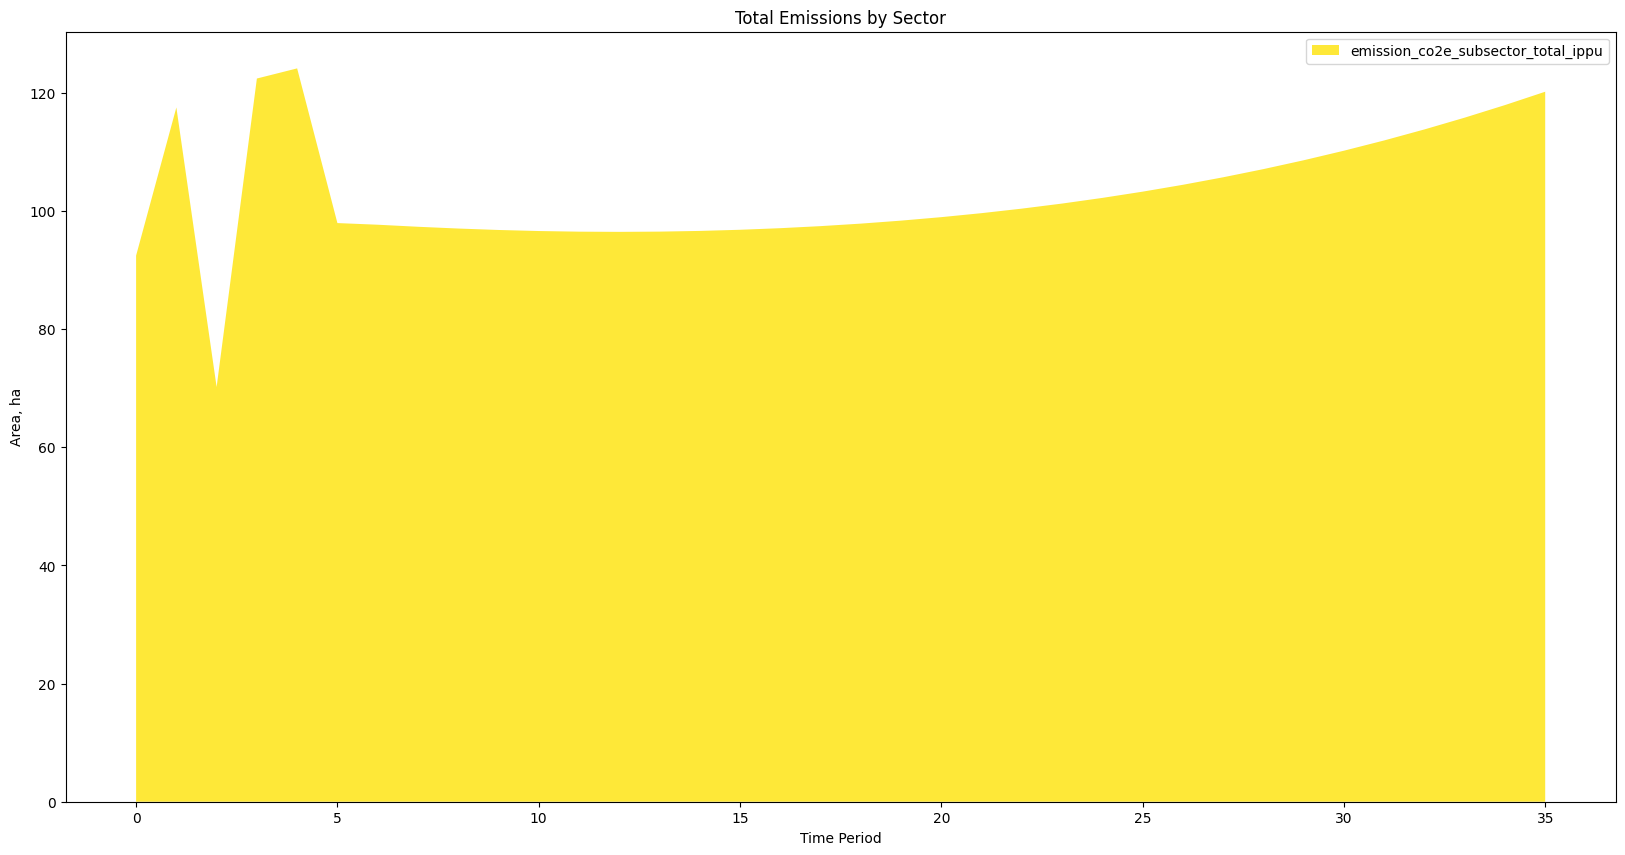

In [29]:
fields_subsector_total = model_attributes.get_sector_emission_total_fields("IPPU")

# setup figure
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_xlabel("Time Period")
ax.set_ylabel("Area, ha")
ax.set_title("Total Emissions by Sector")


# can format 
cmap = plt.colormaps["cividis"]
colors = [cmap(x/len(fields_subsector_total)) for x in range(1, len(fields_subsector_total) + 1)]
dict_format = dict((x, {"color": colors[i] }) for i, x in enumerate(fields_subsector_total)),


sup.plot_stack(
    df_out_ippu,
    fields_subsector_total,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields_subsector_total)),
    figtuple = (fig, ax),
)
ax.legend(loc = "upper right")

In [28]:
file_struct = SISEPUEDEFileStructure()
model_attributes = file_struct.model_attributes

# start with some example dataexamples = SISEPUEDEExamples()
df_input = examples("input_data_frame")

import sisepuede.models.ippu as ippu
model_ippu = ippu.IPPU(model_attributes, )
model_ippu(df_input)




,time_period,dem_ippu_harvested_wood_tonne_paper,dem_ippu_harvested_wood_tonne_wood,emission_co2e_c2f6_ippu_product_use_product_use_ods_other,emission_co2e_c2f6_ippu_production_chemicals,emission_co2e_c2f6_ippu_production_electronics,emission_co2e_c2f6_ippu_production_metals,emission_co2e_c2h3f3_ippu_product_use_product_use_ods_refrigeration,emission_co2e_c2h3f3_ippu_production_chemicals,emission_co2e_c2hf5_ippu_product_use_product_use_ods_other,...,prod_ippu_textiles_tonne,prod_ippu_wood_tonne,qty_ippu_recycled_glass_used_in_production_tonne,qty_ippu_recycled_metals_used_in_production_tonne,qty_ippu_recycled_paper_used_in_production_tonne,qty_ippu_recycled_plastic_used_in_production_tonne,qty_ippu_recycled_rubber_and_leather_used_in_production_tonne,qty_ippu_recycled_textiles_used_in_production_tonne,qty_ippu_recycled_wood_used_in_production_tonne,emission_co2e_subsector_total_ippu
0,0,1.708834e+07,1.929814e+07,0.021341,0.0,0.000818,0.0,0.562002,0.0,0.360359,...,3843.476940,1.833323e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.441352
1,1,1.467957e+07,1.912359e+07,0.018621,0.0,0.000837,0.0,0.554690,0.0,0.376124,...,2878.522579,1.816741e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.517691
2,2,1.085469e+07,1.925429e+07,0.018008,0.0,0.000188,0.0,0.547990,0.0,0.400431,...,929.022413,1.829158e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.192742
3,3,2.531218e+07,1.950390e+07,0.017384,0.0,0.000357,0.0,0.546293,0.0,0.433311,...,1751.404751,1.852871e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.413085
4,4,2.633328e+07,1.963138e+07,0.016715,0.0,0.000334,0.0,0.544395,0.0,0.431805,...,1789.487863,1.864981e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.129075
5,5,1.752970e+07,1.978943e+07,0.016713,0.0,0.000385,0.0,0.544323,0.0,0.431749,...,2254.420543,1.879996e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.945119
6,6,1.747492e+07,1.992910e+07,0.018752,0.0,0.000450,0.0,0.565851,0.0,0.428937,...,2286.760723,1.893264e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.667117
7,7,1.742880e+07,2.007467e+07,0.019027,0.0,0.000447,0.0,0.574161,0.0,0.435236,...,2320.693867,1.907093e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.320781
8,8,1.739089e+07,2.023069e+07,0.019325,0.0,0.000444,0.0,0.583135,0.0,0.442040,...,2357.315377,1.921915e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.021300
9,9,1.736260e+07,2.039649e+07,0.019644,0.0,0.000441,0.0,0.592750,0.0,0.449328,...,2396.520767,1.937666e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.777557


In [ ]:
# list the subsectors in IPPU

In [ ]:
# list output variables here associated with one of the subsectors (your choice)

In [ ]:
# plot an output variable

# Try exploring the `EnergyConsumption` model

- Instantiate the energy consumption model as `model_enercons` using `EnergyConsumption`
- You can check required arguments using `?EnergyConsumption` or `help(EnergyConsumption)`--like `AFOLU` and `CircularEconomy`, it requires the `ModelAttributes` object to initialize

In [19]:
from sisepuede.models.energy_consumption import EnergyConsumption


In [21]:
# instantiate model_enercons here
model_enercons = EnergyConsumption(model_attributes, )

In [31]:
df_input_ec = pd.merge(
    df_input,
    df_out_afolu,
)
df_input_ec = pd.merge(
    df_input_ec,
    df_out_ippu,
)


# try running the model here
model_enercons(df_input_ec)

,time_period,dem_trde_freight_mt_km,dem_trde_private_and_public_passenger_km,dem_trde_regional_passenger_km,emission_co2e_ch4_ccsq_direct_air_capture,emission_co2e_ch4_inen_agriculture_and_livestock,emission_co2e_ch4_inen_cement,emission_co2e_ch4_inen_chemicals,emission_co2e_ch4_inen_electronics,emission_co2e_ch4_inen_glass,...,vehicle_distance_traveled_trns_road_light_diesel,vehicle_distance_traveled_trns_road_light_electricity,vehicle_distance_traveled_trns_road_light_gasoline,vehicle_distance_traveled_trns_road_light_hydrocarbon_gas_liquids,vehicle_distance_traveled_trns_road_light_hydrogen,vehicle_distance_traveled_trns_water_borne,vehicle_distance_traveled_trns_water_borne_diesel,vehicle_distance_traveled_trns_water_borne_electricity,vehicle_distance_traveled_trns_water_borne_hydrogen,vehicle_distance_traveled_trns_water_borne_natural_gas
0,0,336507.486308,7.932608e+07,1.842325e+11,0.0,0.024089,0.0,0.011858,0.000013,0.000080,...,2.351482e+09,1.930703e+07,8.366246e+10,0.0,0.0,2.113605e+06,2.113605e+06,0.0,0.0,0.0
1,1,330420.305054,7.769316e+07,1.746166e+11,0.0,0.023299,0.0,0.017502,0.000017,0.000050,...,2.329749e+09,2.470627e+07,7.897543e+10,0.0,0.0,2.257888e+06,2.257888e+06,0.0,0.0,0.0
2,2,334936.834308,7.885743e+07,1.801448e+11,0.0,0.028642,0.0,0.010759,0.000004,0.000019,...,2.424389e+09,3.588466e+07,8.075842e+10,0.0,0.0,2.260203e+06,2.260203e+06,0.0,0.0,0.0
3,3,343621.019883,8.112191e+07,1.916803e+11,0.0,0.025760,0.0,0.018696,0.000007,0.000031,...,2.567972e+09,5.541141e+07,8.494973e+10,0.0,0.0,2.446850e+06,2.446850e+06,0.0,0.0,0.0
4,4,348112.939843,8.217441e+07,1.939292e+11,0.0,0.021026,0.0,0.020008,0.000008,0.000034,...,2.657343e+09,8.185436e+07,8.559803e+10,0.0,0.0,8.671144e+06,8.671144e+06,0.0,0.0,0.0
5,5,353718.068455,8.358554e+07,1.998902e+11,0.0,0.021483,0.0,0.014131,0.000009,0.000024,...,2.991321e+09,9.214191e+07,9.635609e+10,0.0,0.0,2.588542e+06,2.588542e+06,0.0,0.0,0.0
6,6,358710.859928,8.483580e+07,2.050138e+11,0.0,0.020976,0.0,0.013392,0.000009,0.000030,...,2.890917e+09,8.904914e+07,9.312187e+10,0.0,0.0,2.015854e+06,2.015854e+06,0.0,0.0,0.0
7,7,363951.191947,8.615265e+07,2.105685e+11,0.0,0.020906,0.0,0.013096,0.000010,0.000034,...,2.969228e+09,9.146138e+07,9.564443e+10,0.0,0.0,2.055680e+06,2.055680e+06,0.0,0.0,0.0
8,8,369608.434358,8.758131e+07,2.168312e+11,0.0,0.019532,0.0,0.012955,0.000010,0.000035,...,3.057521e+09,9.418106e+07,9.848850e+10,0.0,0.0,2.099753e+06,2.099753e+06,0.0,0.0,0.0
9,9,375666.663502,8.911800e+07,2.238079e+11,0.0,0.020850,0.0,0.012830,0.000010,0.000034,...,3.155877e+09,9.721074e+07,1.016567e+11,0.0,0.0,2.148045e+06,2.148045e+06,0.0,0.0,0.0


In [ ]:
# list the subsectors in EnergyConsumption

In [ ]:
# list output variables here associated with one of the subsectors (your choice)

In [ ]:
# plot an output variable

# A note on `EnergyProduction`

- The energy production model can be run independently, but it requires adding a number of inputs manually that are not currently available in the examnple dataset
- In general, it should be run as part of the integrated model to ensure assumptions about energy demands are passed appropriately
- A separate `EnergyProduction` model tutorial is under development

# Now that we've looked at each sector independently, let's look at initializing the DAG

- Use the `SISEPUEDEModels` class to store all models at once
- Callable
- Can project the models in order using this method
- Can initialize the `EnergyProduction` model (Julia) or not
- Note that, to use this, we also need the `SISEPUEDEFileStructure` object to point to directories storing NEMO input files
- In the next tutorial, we'll look at the self-contained `SISEPUEDE` object, which stores the model, database system, and sampling system

In [4]:
from sisepuede.manager.sisepuede_models import SISEPUEDEModels

##  First, we can initialize a model DAG **without** fuel production
- Can run all subsectors except for **ENTC**, **ENST**, and **FGTV**
- Often useful when validating, calibrating, or exploring other sectors/subsectors 

In [38]:
models_noenerprod = SISEPUEDEModels(
    model_attributes,
    allow_electricity_run = False, 
)

###  Run the models without Energy Production

This will produce a lot of fields.

In [39]:
df_out_noenerprod = models_noenerprod(df_input, )


In [35]:
df_out_noenerprod.head()

,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,area_agrc_crops_other_woody_perennial,area_agrc_crops_pulses,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,0.0,367983.831774,68239.857458,80.234375,79198.541655,6714.566582,1.154590e+06,0.0,357.684133,...,1607.703461,955073.693482,19786.484805,7.132381e+06,0.0,985.642069,2.422231e+06,2.104457e+07,166526.651285,147.841681
1,1,0.0,362096.267342,67148.052539,78.950664,77931.403057,6607.136744,1.136117e+06,0.0,351.961359,...,1616.909034,977244.208052,22830.850901,8.141189e+06,0.0,1147.287929,2.270951e+06,2.014820e+07,170203.458526,150.239733
2,2,0.0,360603.256374,66871.184789,78.625131,77610.072930,6579.893913,1.131433e+06,0.0,350.510137,...,1572.095458,943834.205917,20014.830969,1.258079e+07,0.0,1387.559377,2.281962e+06,2.522074e+07,170020.494166,144.369498
3,3,0.0,359180.755369,66607.392585,78.314972,77303.918161,6553.937670,1.126969e+06,0.0,349.127451,...,1483.984815,950000.734264,22121.396585,6.126346e+06,0.0,1454.827115,2.421785e+06,2.532944e+07,161700.601978,147.613979
4,4,0.0,358002.730124,66388.936588,78.058118,77050.380170,6532.442353,1.123273e+06,0.0,347.982398,...,1579.787589,950624.475419,19546.265136,6.938924e+06,0.0,1122.623719,2.150882e+06,2.351716e+07,166345.161971,163.535551


## Now, let's try it with the full energy model--`EnergyConsumption` and `EnergyProduction`
- The first time you run this, Julia will be installed in the environment--this can take a few minutes
- On each initialization, it will take a few seconds to setup the julia call environment, but this is a one-time connection per each session

In [5]:
models_all = SISEPUEDEModels(
    model_attributes,
    allow_electricity_run = True,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
    fp_nemomod_temp_sqlite_db = file_struct.fp_sqlite_tmp_nemomod_intermediate,
)

[juliapkg] Found dependencies: /Users/usuario/git/sisepuede/sisepuede/julia/pyjuliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ^1.11.5
[juliapkg] Using Julia 1.11.5 at /Users/usuario/.julia/juliaup/julia-1.11.5+0.aarch64.apple.darwin14/bin/julia
[juliapkg] Using Julia project at /Users/usuario/git/sisepuede/sisepuede/julia
[juliapkg] Writing Project.toml:
             [deps]
             Cbc = "9961bab8-2fa3-5c5a-9d89-47fab24efd76"
             Clp = "e2554f3b-3117-50c0-817c-e040a3ddf72d"
             DataFrames = "a93c6f00-e57d-5684-b7b6-d8193f3e46c0"
             GLPK = "60bf3e95-4087-53dc-ae20-288a0d20c6a6"
             HiGHS = "87dc4568-4c63-4d18-b0c0-bb2238e4078b"
             Ipopt = "b6b21f68-93f8-5de0-b562-5493be1d77c9"
           

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/git/sisepuede/sisepuede/julia/Project.toml`
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.2.2
  [a93c6f00] + DataFrames v1.7.0
  [60bf3e95] + GLPK v1.2.1
  [87dc4568] + HiGHS v1.18.1
  [b6b21f68] + Ipopt v1.10.6
  [4076af6c] + JuMP v1.26.0
  [a3c327a0] + NemoMod v2.0.0 `https://github.com/sei-international/NemoMod.jl.git#61e63e0`
  [6099a3de] + PythonCall v0.9.25
  [0aa819cd] + SQLite v1.6.1
⌅ [458c3c95] + OpenSSL_jll v3.0.16+0
    Updating `~/git/sisepuede/sisepuede/julia/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.6.0
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.2.2
  [523fee87] + CodecBzip2 v0.8.5
  [944b1d66] + CodecZlib v0.7.8
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.16.0
  [992eb4ea] + CondaPkg v0.2.29
  [88353bc9] + ConfParser v0.1.2
  [a8cc5b0e] + Crayons v4.1.1
  [a10d1c49] + DBInterface v2.6.1
  [9a962f9c] + DataAPI v1.16.0
  [a93c6f

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1156.6 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


##  Now, we can run the full DAG, including the EnergyProduction model

In [6]:
#warnings.filterwarnings("ignore")
df_input2 = pd.read_csv("/Users/usuario/git/sisepuede_region_nbs/mongolia/data/mongolia_data_latest_20250620.csv")
models_all.model_ippu(df_input2, )

,time_period,dem_ippu_harvested_wood_tonne_paper,dem_ippu_harvested_wood_tonne_wood,emission_co2e_c2f6_ippu_product_use_product_use_ods_other,emission_co2e_c2f6_ippu_production_chemicals,emission_co2e_c2f6_ippu_production_electronics,emission_co2e_c2f6_ippu_production_metals,emission_co2e_c2h3f3_ippu_product_use_product_use_ods_refrigeration,emission_co2e_c2h3f3_ippu_production_chemicals,emission_co2e_c2hf5_ippu_product_use_product_use_ods_other,...,prod_ippu_textiles_tonne,prod_ippu_wood_tonne,qty_ippu_recycled_glass_used_in_production_tonne,qty_ippu_recycled_metals_used_in_production_tonne,qty_ippu_recycled_paper_used_in_production_tonne,qty_ippu_recycled_plastic_used_in_production_tonne,qty_ippu_recycled_rubber_and_leather_used_in_production_tonne,qty_ippu_recycled_textiles_used_in_production_tonne,qty_ippu_recycled_wood_used_in_production_tonne,emission_co2e_subsector_total_ippu
0,0,79672.948427,1.499843e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16092.921184,1.424851e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.695784
1,1,79797.321853,1.510975e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16096.376000,1.435426e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.752882
2,2,80270.768959,1.553598e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16109.509625,1.475918e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.759458
3,3,80924.341168,1.613740e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16127.547769,1.533053e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.772852
4,4,81401.971934,1.659024e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16140.638226,1.576073e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.778388
5,5,81010.827394,1.621123e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16129.972353,1.540067e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.774666
6,6,81150.489757,1.634411e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16133.796577,1.552690e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.776977
7,7,81580.908610,1.675627e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16145.564778,1.591845e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.777196
8,8,82183.436785,1.734466e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16161.963704,1.647743e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.787965
9,9,82748.324976,1.791149e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16177.240972,1.701591e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.798243


In [7]:
#df_input["nemomod_entc_reserve_margin"] = 1.15
df_out_all = models_all(df_input, )


2025-29-Jun 16:07:33.132 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-29-Jun 16:07:33.270 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-29-Jun 16:07:40.224 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-29-Jun 16:09:08.748 Finished modeling scenario.


In [8]:
df_out_all[[x for x in df_out_all.columns if "emission_co2e_subsector" in x]].tail()



,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_scoe,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trns,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
31,1.295932,0.0,30.092954,9.015662,-27.697272,25.595030,111.786446,10.802519,0.337017,1.328089,6.864168,14.782890,84.684656,1.887544,2.966099
32,1.287262,0.0,30.700587,9.177193,-28.084968,25.448042,113.649990,10.822109,0.338933,1.330951,6.996489,14.704829,87.305024,1.918281,3.023404
33,1.278656,0.0,31.331651,9.345266,-28.475958,25.307490,115.642667,10.841528,0.340856,1.333821,7.135796,14.627410,90.027626,1.949525,3.081941
34,1.270115,0.0,31.986260,9.519928,-28.869531,25.174989,117.768492,10.860779,0.342782,1.336688,7.282134,14.550626,92.852356,1.981274,3.141688
35,1.261637,0.0,32.636442,9.692963,-29.265498,25.433976,120.030333,10.879861,0.344715,1.339564,7.435750,14.474471,95.776588,2.013509,3.202589


In [8]:
models_all.model_enerprod.julia_main.seval("using Pkg;")


In [9]:
jm = models_all.model_enerprod.julia_main



In [14]:
fp = "/Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite"

In [12]:
jm.HiGHS

HiGHS

In [ ]:
jm.NemoMod.calculatescenario(
    fp,r
    #optimizer = "HiGHS",
)

In [18]:
# look for a variable you want to plot
df_out_all[[x for x in df_out_all.columns if "emission_co2e_subsector" in x]]

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_scoe,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trns,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
0,1.584478,0.0,0.0,-25.538740,34.955562,92.323613,10.232454,0.284571,1.240654,5.408010,17.917017,43.813502,1.194832,1.799645
1,1.572591,0.0,0.0,-26.783584,35.550963,117.400000,10.189879,0.284090,1.243502,4.777919,17.925521,41.755424,1.181569,1.769777
2,1.665478,0.0,0.0,-19.986328,26.430140,70.076960,9.833807,0.285389,1.246277,4.587107,17.721314,42.378982,1.193562,1.793225
3,1.554525,0.0,0.0,-13.536215,47.899635,122.294593,10.373137,0.287317,1.249005,4.909771,17.745855,44.782787,1.215421,1.837838
4,1.535587,0.0,0.0,-39.054588,48.044472,124.008505,10.205386,0.289048,1.251816,4.955352,17.557830,45.549952,1.234366,1.862077
5,1.535521,0.0,0.0,-34.596052,34.838017,97.824882,10.229412,0.290675,1.254600,4.638844,17.457973,45.659023,1.251805,1.891577
6,1.536231,0.0,0.0,-15.745217,33.832981,97.545957,10.253864,0.292199,1.257390,5.084611,17.355884,46.673433,1.269835,1.917773
7,1.518798,0.0,0.0,-17.131690,33.056731,97.198690,10.278112,0.293756,1.260185,5.121714,17.250693,47.336955,1.288461,1.945185
8,1.485179,0.0,0.0,-18.169750,32.252899,96.898262,10.302159,0.295369,1.262983,5.160421,17.141281,48.105886,1.308068,1.974810
9,1.504057,0.0,0.0,-18.980276,32.188789,96.653559,10.326005,0.297038,1.265781,5.201003,17.028348,48.977602,1.328608,2.006359


In [ ]:
# plot it

In [34]:
# information about variables
model_attributes.build_variable_dataframe_by_sector(
    None,
    include_model_variable = True,
    include_model_variable_attributes = True,
    include_simplex_group_as_trajgroup = False,
    include_time_periods = False,
)

,subsector,variable_field,variable,area,energy,length,mass,monetary,power,volume,emission_gas
0,Agriculture,ef_agrc_anaerobicdom_rice_kg_ch4_ha,:math:\text{CH}_4 Crop Anaerobic Decomposition...,ha,None,None,kg,None,None,None,ch4
1,Agriculture,ef_agrc_biomass_bevs_and_spices_tonne_co2_ha,:math:\text{CO}_2 Crop Biomass Emission Factor,ha,None,None,tonne,None,None,None,co2
2,Agriculture,ef_agrc_biomass_burning_ch4,:math:\text{CH}_4 Crop Biomass Burning Emissio...,None,None,None,None,None,None,None,ch4
3,Agriculture,ef_agrc_biomass_burning_n2o,:math:\text{N}_2\text{O} Crop Biomass Burning ...,None,None,None,None,None,None,None,n2o
4,Agriculture,ef_agrc_biomass_fruits_tonne_co2_ha,:math:\text{CO}_2 Crop Biomass Emission Factor,ha,None,None,tonne,None,None,None,co2
...,...,...,...,...,...,...,...,...,...,...,...
2372,Wastewater Treatment,mcf_trww_treated_septic,Wastewater Treatment Methane Correction Factor,None,None,None,None,None,None,None,None
2373,Wastewater Treatment,mcf_trww_untreated_no_sewerage,Wastewater Treatment Methane Correction Factor,None,None,None,None,None,None,None,None
2374,Wastewater Treatment,mcf_trww_untreated_with_sewerage,Wastewater Treatment Methane Correction Factor,None,None,None,None,None,None,None,None
2375,Wastewater Treatment,physparam_krem_sludge_factor_treated_advanced_...,:math:\text{K}_{REM} Sludge Factor,None,None,None,None,None,None,None,None
